In [1]:
!pip install imblearn shap

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy.stats import variation
from sklearn.impute import SimpleImputer
from matplotlib import rc

In [3]:
shap.initjs()
# Use the computer modern font for the plots
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'axes.grid' : False}
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1)

In [4]:
# Hyperparameters for various functions
seed = 0
smote_sample_strategy = 0.5
random_under_sample_strategy = 0.9
smote_k_neighbors = 5
k_features = 5

In [5]:
root_dir = os.path.dirname(os.getcwd())
df = pd.read_csv(os.path.join(root_dir, "data/processed/data_cleaned.csv"))

/tmp/ipykernel_82060/2404526448.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(root_dir, "data/processed/data_cleaned.csv"))


In [6]:
df.head()

,subject,gender,age,hand,x_coordinate,y_coordinate,timestamp,state,date,azimuth,altitude,pressure,control,session
0,T001,NaN,NaN,R,1493,9752,2098403,1,1970-01-01 12:34:58.403000,1990,720,6,N,u00005s00001_hw00001.svc
1,T001,NaN,NaN,R,1490,9752,2098411,1,1970-01-01 12:34:58.411000,1990,720,168,N,u00005s00001_hw00001.svc
2,T001,NaN,NaN,R,1490,9752,2098418,1,1970-01-01 12:34:58.418000,1990,720,328,N,u00005s00001_hw00001.svc
3,T001,NaN,NaN,R,1490,9752,2098426,1,1970-01-01 12:34:58.426000,1990,720,480,N,u00005s00001_hw00001.svc
4,T001,NaN,NaN,R,1489,9752,2098433,1,1970-01-01 12:34:58.433000,1990,720,667,N,u00005s00001_hw00001.svc


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250802 entries, 0 to 250801
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   subject       250802 non-null  object 
 1   gender        51060 non-null   object 
 2   age           51060 non-null   float64
 3   hand          250802 non-null  object 
 4   x_coordinate  250802 non-null  int64  
 5   y_coordinate  250802 non-null  int64  
 6   timestamp     250802 non-null  int64  
 7   state         250802 non-null  int64  
 8   date          250802 non-null  object 
 9   azimuth       250802 non-null  int64  
 10  altitude      250802 non-null  int64  
 11  pressure      250802 non-null  int64  
 12  control       250802 non-null  object 
 13  session       250802 non-null  object 
dtypes: float64(1), int64(7), object(6)
memory usage: 26.8+ MB


In [8]:
def create_metrics(df):
    df_temp = df.copy()
    grouping_vars = ['subject','session']
    df_temp["dx"] = df_temp.groupby(grouping_vars)["x_coordinate"].diff()
    df_temp["dy"] = df_temp.groupby(grouping_vars)["y_coordinate"].diff()
    df_temp["delta_altitude"] = df_temp.groupby(grouping_vars)["altitude"].diff().abs()
    df_temp["delta_pressure"] = df_temp.groupby(grouping_vars)["pressure"].diff().abs()
    df_temp["delta_azimuth"] = df_temp.groupby(grouping_vars)["azimuth"].diff().abs()
    # Calculate the delta distance as the Euclidean distance for each group
    df_temp["distance"] = np.sqrt(df_temp["dx"] ** 2 + df_temp["dy"] ** 2)
    # Compute time difference in seconds
    df_temp["dt"] = pd.to_datetime(df_temp["date"]).diff().dt.total_seconds()
    # Calculate speed
    df_temp["speed"] = df_temp["distance"] / df_temp["dt"]
    return df_temp

In [9]:
def aggregate_features(df_input):
    variability_data = []
    # Iterate over subjects
    for subject in df_input.subject.unique():
        subject_df = df_input[df_input.subject == subject]
        # Iterate over sessions for each subject
        for session in subject_df.session.unique():
            session_df = subject_df[
                (subject_df.session == session) & (subject_df.subject == subject)
            ]
            # Calculate variability (coefficient of variation) for speed
            speed_variability = variation(session_df["speed"].dropna())
            
            # Collect the information (session, subject, and speed variability)
            variability_data.append({
                "subject": subject,
                "session": session,
                "speed_variability": speed_variability
            })

    # Convert the variability data into a DataFrame
    variability_df = pd.DataFrame(variability_data)
    # Group by subject, session, and control, and calculate mean values for other features
    mean_df = df_input.groupby(['subject','session','control']).agg({
        "altitude":'mean',
        "pressure":'mean',
        "azimuth":'mean',        
        "delta_altitude":'mean',
        "delta_pressure":'mean',
        "delta_azimuth":'mean',
        # "distance":'mean',
        # "speed":'mean',
    }).reset_index()

    # Merge the variability_df with mean_df on subject and session
    merged_df = pd.merge(mean_df, variability_df, on=["subject", "session"], how="left")
    merged_df = merged_df.drop(["session","subject"], axis=1)
    return merged_df

In [10]:
df = create_metrics(df)
# Check the number of NaNs in the dataset
print(df.isna().sum())

subject                0
gender            199742
age               199742
hand                   0
x_coordinate           0
y_coordinate           0
timestamp              0
state                  0
date                   0
azimuth                0
altitude               0
pressure               0
control                0
session                0
dx                   124
dy                   124
delta_altitude       124
delta_pressure       124
delta_azimuth        124
distance             124
dt                     1
speed                124
dtype: int64


In [11]:
numerical_df = df.select_dtypes(include=[np.number])
categorical_df = df.select_dtypes(exclude=[np.number])

# Initialize SimpleImputer with median strategy and set it to return a DataFrame
imputer = SimpleImputer(strategy='median').set_output(transform="pandas")

# Fit and transform the numerical columns
numerical_imputed = imputer.fit_transform(numerical_df)
df = pd.concat([numerical_imputed,categorical_df],axis=1)

In [12]:
df_metrics = aggregate_features(df)
df_metrics["control_numeric"] = (df_metrics["control"] == "Y").astype(int)
df_metrics = df_metrics.drop(["control"], axis=1)
df_metrics.head()

,altitude,pressure,azimuth,delta_altitude,delta_pressure,delta_azimuth,speed_variability,control_numeric
0,744.736842,1641.735324,3372.130567,0.779352,84.017713,7.100202,0.353704,1
1,817.502444,1003.782991,1941.793744,0.767351,70.954057,7.409580,0.328157,1
2,748.940962,1014.970785,3194.357882,0.882532,29.564212,18.654900,0.307191,1
3,799.971469,936.285307,1673.128864,1.046125,45.365668,6.305278,0.384184,1
4,759.467397,1108.660030,694.639124,0.806371,35.923345,14.196117,0.283582,1


In [13]:
# Number of sessions for healthy subjects (control == 'Y')
no_healthy_sessions = len(df_metrics[df_metrics['control_numeric'] == 1])

# Number of sessions for sick subjects (control == 'N')
no_sick_sessions = len(df_metrics[df_metrics['control_numeric'] == 0])

# Print the results
print(f"Number of sessions for the controlled group: {no_healthy_sessions}")
print(f"Number of sessions for the non-controlled group: {no_sick_sessions}")

Number of sessions for the controlled group: 20
Number of sessions for the non-controlled group: 104


Features:
- Mean Altitude
- Mean Pressure
- Mean Azimuth
- Mean Delta Altitude
- Mean Delta Pressure
- Mean Delta Azimuth
- Speed variability

Class label: `control_numeric`

Where: 
- 0 = patient with PD
- 1 = healthy patient

In [14]:
X = df_metrics.drop(["control_numeric"], axis=1)
y = df_metrics["control_numeric"].copy()
print(y.value_counts())

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

control_numeric
0    104
1     20
Name: count, dtype: int64


In [15]:
%%time
def train_rf(perform_fs=False):
    pipeline = imbPipeline([])
    if perform_fs:
        pipeline.steps.append(
                ("selector", SelectKBest(mutual_info_classif, k=k_features))
            )
    pipeline.steps.extend([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(sampling_strategy=smote_sample_strategy, k_neighbors=smote_k_neighbors, random_state=seed)),
        ("classifier", RandomForestClassifier(random_state=0))
    ])
    pipeline.fit(X_train, y_train)
    train_accuracy = pipeline.score(X_train, y_train)
    test_accuracy = pipeline.score(X_test, y_test)
    return pipeline

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 10.5 µs


## Part 1: Performing without feature selection

In [16]:
rf_pipeline = train_rf(False)
rf_model = rf_pipeline["classifier"]
feature_importances = rf_model.feature_importances_

In [17]:
numerical_features = X_train.columns.copy()
sorted(zip(list(feature_importances), numerical_features), reverse=True) 

[(0.356439183886766, 'speed_variability'),
 (0.22050436921140462, 'delta_pressure'),
 (0.1297604196561075, 'delta_altitude'),
 (0.09692249083035849, 'pressure'),
 (0.08598583496845574, 'altitude'),
 (0.07913457435818733, 'delta_azimuth'),
 (0.031253127088720405, 'azimuth')]

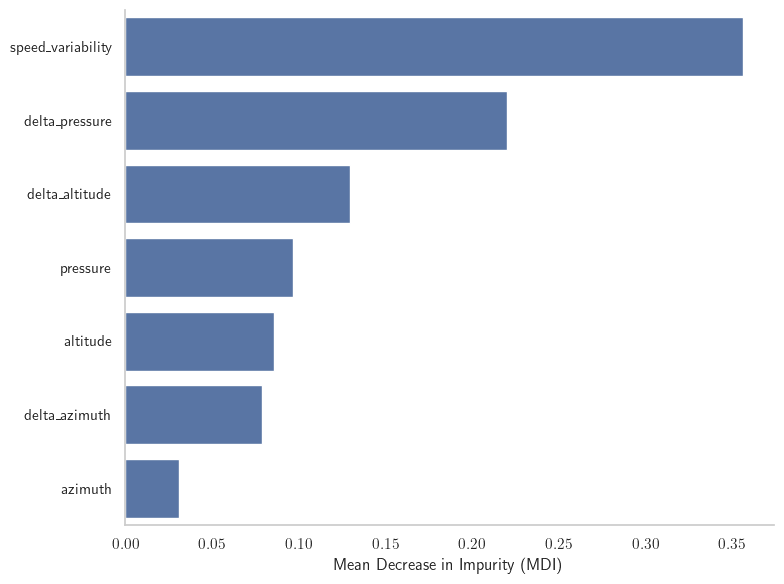

In [18]:
def plot_mdi_importance_plot(rf_pipeline):
    # https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
    feature_names = rf_pipeline[:-1].get_feature_names_out()

    mdi_importances = pd.Series(
        rf_pipeline[-1].feature_importances_, index=feature_names
    ).sort_values(ascending=False)

    # Create the horizontal bar plot with Seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(
        x=mdi_importances.values, 
        y=mdi_importances.index, 
        orient='h', 
        # palette='viridis'
    )
    ax.set_xlabel("Mean Decrease in Impurity (MDI)", fontsize=12)
    ax.set_ylabel(None)
    # ax.set_title("Random Forest Feature Importances (MDI)", fontsize=14)
    plt.tight_layout()
    if len(feature_names) < len(X_train.columns):
        plt.savefig(os.path.join(root_dir,"graphs/rf_mdi_importance_fs.pdf"), bbox_inches="tight")
    else:
        plt.savefig(os.path.join(root_dir,"graphs/rf_mdi_importance.pdf"), bbox_inches="tight")
    plt.show()
plot_mdi_importance_plot(rf_pipeline)

In [19]:
def plot_permutation_importance_plot(pipeline):
    result = permutation_importance(
        pipeline, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=-1
    )
    feature_names = pipeline[:-1].get_feature_names_out()
    # print(len(feature_names))
    # print(len(result.importances_mean))
    perm_imp_df = pd.DataFrame({'Feature': feature_names, 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)
    plt.figure(figsize=(6, 6))
    plt.bar(perm_imp_df['Feature'], perm_imp_df['Permutation Importance'])
    plt.xlabel('Feature')
    plt.ylabel('Permutation Importance')
    plt.title('Permutation Feature Importance')
    plt.xticks(rotation=45, ha='right')  # Adjust rotation for better visibility
    plt.tight_layout()
    plt.show()
# plot_permutation_importance_plot(rf_pipeline)

In [20]:
explainer = shap.TreeExplainer(rf_model, feature_names=numerical_features)

In [21]:
# RF's predictions
rf_pipeline.predict(X_test)[:3]

array([1, 0, 0])

In [22]:
# Actual labels
y_test[:3]

8     1
50    0
43    0
Name: control_numeric, dtype: int64

The first id is a control patient and the model predicted this correctly.

The second and third ids are both non-control patients and the model predicted both correctly.

In [23]:
control_id = 0 # First id that correctly predicted as a healthy patient
noncontrol_id = 1 # Second id that was correctly predicted as a PD patient

In [24]:
feature_values, _ = rf_pipeline[:-1].fit_resample(X_train, y_train)
explanation = explainer(feature_values)
shap_values = explainer.shap_values(feature_values)

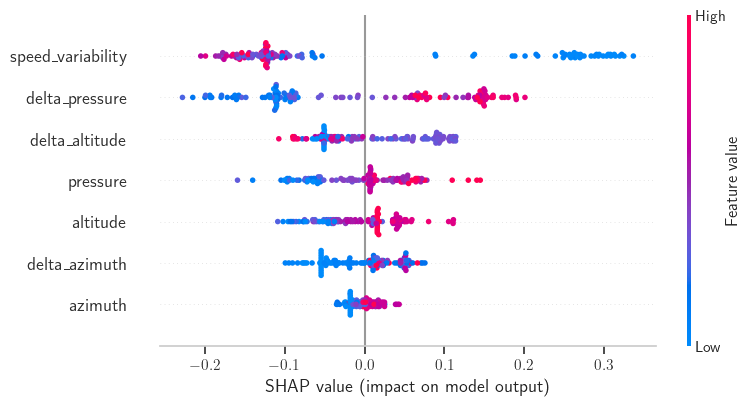

In [25]:
shap.plots.beeswarm(explanation[:,:,1], show=False)
plt.savefig(os.path.join(root_dir,"graphs/shap_beeswarm.pdf"), bbox_inches="tight")
plt.show()

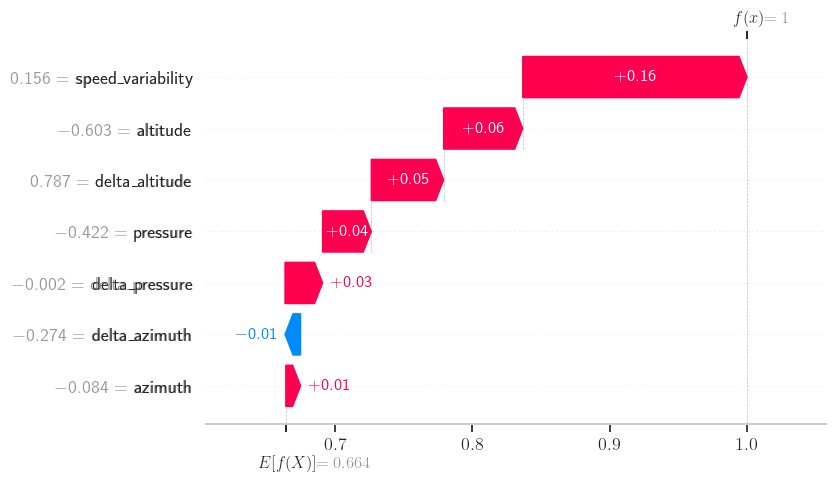

In [26]:
# Waterfall for PD patient
shap.plots.waterfall(explanation[control_id,:,control_id], show=False)
plt.savefig(os.path.join(root_dir,"graphs/shap_waterfall_control.pdf"), bbox_inches="tight")
plt.show()

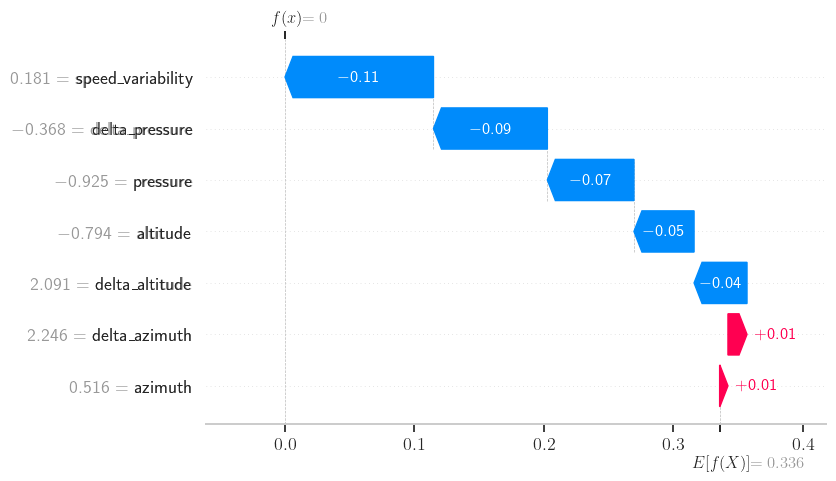

In [27]:
# Waterfall for healthy patient
shap.plots.waterfall(explanation[noncontrol_id,:,noncontrol_id], show=False)
plt.savefig(os.path.join(root_dir,"graphs/shap_waterfall_noncontrol.pdf"), bbox_inches="tight")
plt.show()

In [28]:
shap.plots.force(explainer.expected_value[0], shap_values[control_id][:,control_id], X_test.iloc[control_id, :])

In [29]:
shap.plots.force(explainer.expected_value[1], shap_values[noncontrol_id][:,noncontrol_id], X_test.iloc[noncontrol_id, :])

## Part 2: Performing with feature selection

In [30]:
# Check number of classes after applying smote
temp_pipeline = imbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(sampling_strategy=smote_sample_strategy, k_neighbors=smote_k_neighbors, random_state=seed)),
])
X_tmp, y_tmp = temp_pipeline.fit_resample(X, y)
y_tmp.value_counts()

control_numeric
0    104
1     52
Name: count, dtype: int64

In [31]:
rf_pipeline_fs = train_rf(True)
rf_model_fs = rf_pipeline_fs["classifier"]
feature_importances = rf_model_fs.feature_importances_

In [32]:
numerical_features_fs = rf_pipeline_fs[:-1].get_feature_names_out()
sorted(zip(list(feature_importances), numerical_features_fs), reverse=True) 

[(0.4337018356533905, 'speed_variability'),
 (0.2532006697908999, 'delta_pressure'),
 (0.1288349815356733, 'altitude'),
 (0.1078290392780118, 'delta_altitude'),
 (0.07643347374202457, 'pressure')]

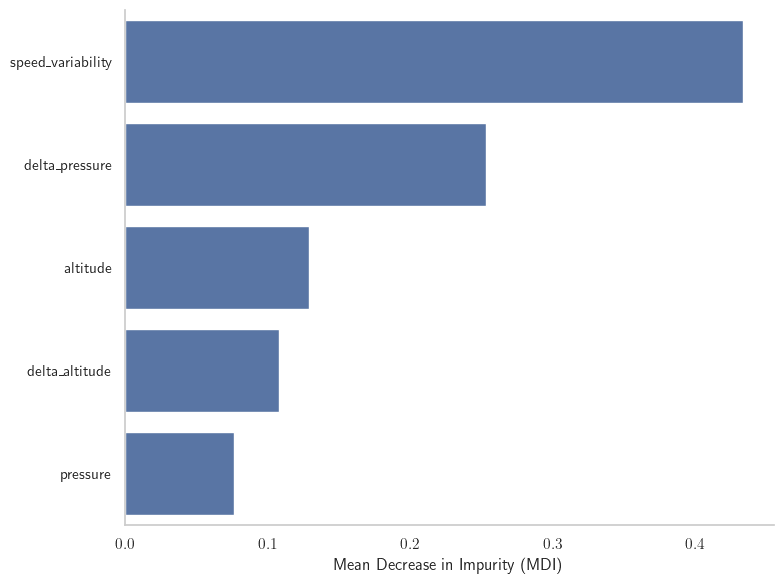

In [33]:
plot_mdi_importance_plot(rf_pipeline_fs)

In [34]:
X_test_fs = X_test[numerical_features_fs.tolist()]

In [35]:
explainer = shap.TreeExplainer(rf_model_fs, feature_names=numerical_features_fs)

In [36]:
# RF's predictions
rf_pipeline.predict(X_test)[:3]

array([1, 0, 0])

In [37]:
# Actual labels
y_test[:3]

8     1
50    0
43    0
Name: control_numeric, dtype: int64

The first id is a control patient and the model predicted this correctly.

The second and third ids are both non-control patients and the model predicted both correctly.

In [38]:
control_id = 0 # First id that correctly predicted as a healthy patient
noncontrol_id = 1 # Second id that was correctly predicted as a PD patient

In [39]:
feature_values, _ = rf_pipeline_fs[:-1].fit_resample(X_train, y_train)
explanation = explainer(feature_values)
shap_values = explainer.shap_values(feature_values)

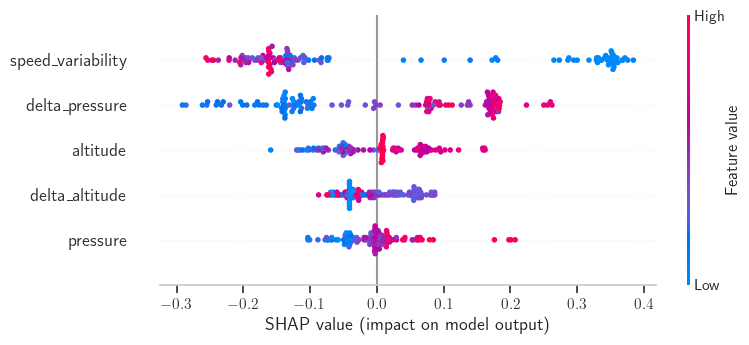

In [40]:
shap.plots.beeswarm(explanation[:,:,1], show=False)
plt.savefig(os.path.join(root_dir,"graphs/shap_beeswarm_fs.pdf"), bbox_inches="tight")
plt.show()

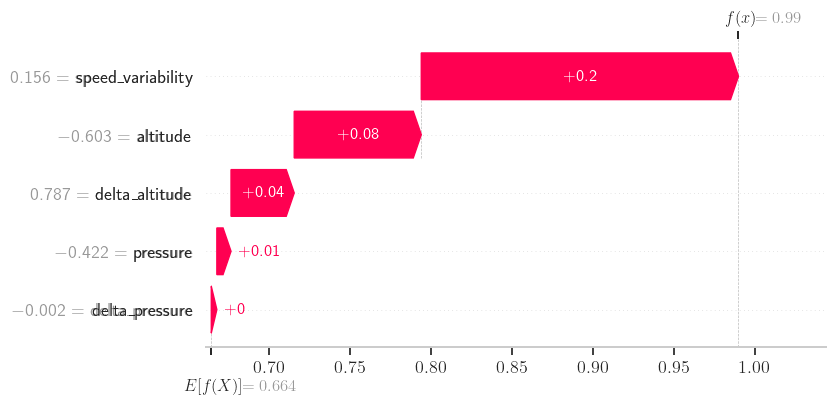

In [41]:
shap.plots.waterfall(explanation[control_id,:,control_id], show=False)
plt.savefig(os.path.join(root_dir,"graphs/shap_waterfall_control_fs.pdf"), bbox_inches="tight")
plt.show()

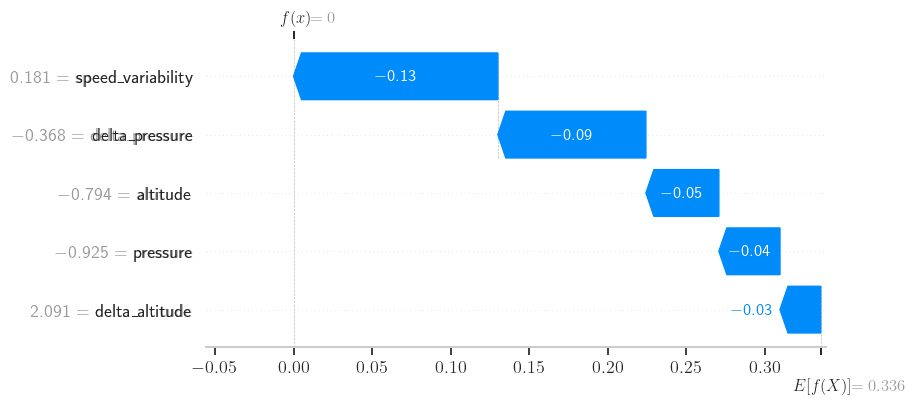

In [42]:
shap.plots.waterfall(explanation[noncontrol_id,:,noncontrol_id], show=False)
plt.savefig(os.path.join(root_dir,"graphs/shap_waterfall_noncontrol_fs.pdf"), bbox_inches="tight")
plt.show()

In [43]:
shap.plots.force(explainer.expected_value[1], shap_values[control_id][:,control_id], X_test_fs.iloc[control_id, :], X_test_fs.columns.tolist())

In [44]:
shap.plots.force(explainer.expected_value[1], shap_values[noncontrol_id][:,noncontrol_id], X_test_fs.iloc[noncontrol_id, :], X_test_fs.columns.tolist())